In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import scipy
import xarray as xr
import pandas as pd
import numpy as np

In [5]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 14})

In [6]:
import warnings

In [7]:
def find_cnv_header(filepath, find_columns=True):
    f = open(filepath, "r")
    line = 'init'
    header = 0
    names = []
    
    while "*END*" not in line:
        line = f.readline()
        if "# name " in line:
            names.append(line[11:].split(":")[0].strip(" "))
        header+=1
    return header-1, names

def load_cnv(filepath):
    header, names = find_cnv_header(filepath)
    df = pd.read_csv(filepath, header=header, delim_whitespace=True, names=names)
    return df

In [8]:
def depth_bin(ctd, dz=1):
    dmin, dmax = np.floor(np.min(ctd['DEPTH'])), np.ceil(np.max(ctd['DEPTH']))
    depth_bins = np.arange(dmin, dmax+dz, dz)
    depth_bounds = np.arange(dmin-dz/2., (dmax+dz)+dz/2., dz)
    
    f = scipy.interpolate.interp1d(depth_bins, depth_bins, kind='nearest', bounds_error=False)
    ctd['RDEPTH'] = f(ctd['DEPTH'])
    ctd = ctd.groupby('RDEPTH').mean()
    return ctd

In [9]:
def shear(u, v, z):
    uz = np.zeros_like(u)
    tmp = np.diff(u)/np.diff(z)
    uz[1:-1] = (tmp[1:] + tmp[:-1])/2.
    
    vz = np.zeros_like(v)
    tmp = np.diff(v)/np.diff(z)
    vz[1:-1] = (tmp[1:] + tmp[:-1])/2.
    
    return uz, vz

def read_ladcp(expname, stn, seafloor=None):
    stn_filled = stn_filled = str(stn).zfill(3)
    ladcp = scipy.io.loadmat(f'../UnderwayProcessing/{expname}/script/processed/{stn_filled}/{stn_filled}.mat', simplify_cells=True)['dr']
    ladcp["z"] = ladcp["z"].astype(np.float64)
    #ladcp['uz'], ladcp['vz'] = shear(ladcp['u'], ladcp['v'], ladcp['z'])
    return ladcp

def find_header_line(filepath):
    f = open(filepath, "r")
    line = 'init'
    header = 0
    while line[0] != "1":
        line = f.readline()
        header+=1
    return header-2

def read_ctd(expname, stn, return_diag=True):
    stn_filled = str(stn).zfill(3)
    #if expname=="BLT1":
    #    filename = f"blt{expname[-1]}st{stn_filled}_tps"
    #if expname=="BLT2":
    filename = f"dblt{expname[-1]}st{stn_filled}"
    ctd = load_cnv(f"../../data/BLT2/interim/CTD/{filename}.cnv")
    ctd["DEPTH"] = -gsw.z_from_p(ctd["prDM"].values, ctd["latitude"].values)
    
    #isolate downcast:
    downcast = np.arange(np.where(ctd['DEPTH'] > 20.)[0][0],np.argmax(ctd['DEPTH']), 1)
    ctd = ctd.iloc[downcast]
    
    # Is this the correct thing to do? Probably not...
    if np.any(ctd['DEPTH'][1:].values < ctd['DEPTH'][:-1].values):
        print("Depth binning")
        ctd = depth_bin(ctd)
        
    if return_diag:
        return ctd, ctd_diag
    else:
        return ctd

def read_vke(expname, stn):
    stn_filled = str(stn).zfill(3)
    filepath = f'../LADCP/{expname}/VKE/{stn_filled}.VKE'
    vke = pd.read_csv(filepath, header=find_header_line(filepath), delim_whitespace=True)
    vke = pd.read_csv(
        f'../LADCP/{expname}/VKE/{stn_filled}.VKE',
        header=find_header_line(filepath),
        names=[
            e.replace('{', '').replace('}','')
            for e in list(vke.columns)[1:]
        ]+["fill"],
        delim_whitespace=True,
    )
    return vke

In [12]:
rockall = -xr.open_dataarray("../../data/ETOPO1/ETOPO1_Bed_g_gmt4.nc").sel(x=slice(-15, -9), y=slice(53, 59))
rockall.attrs["long_name"] = "depth [m]"

blt1_canyon = xr.open_dataarray("../../data/RockallTrough/blt1_mb.nc")
blt2_canyon = xr.open_dataarray("../../data/RockallTrough/blt2_mb.nc")

ValueError: found the following matches with the input file in xarray's IO backends: ['netcdf4', 'h5netcdf']. But their dependencies may not be installed, see:
http://xarray.pydata.org/en/stable/user-guide/io.html 
http://xarray.pydata.org/en/stable/getting-started-guide/installing.html

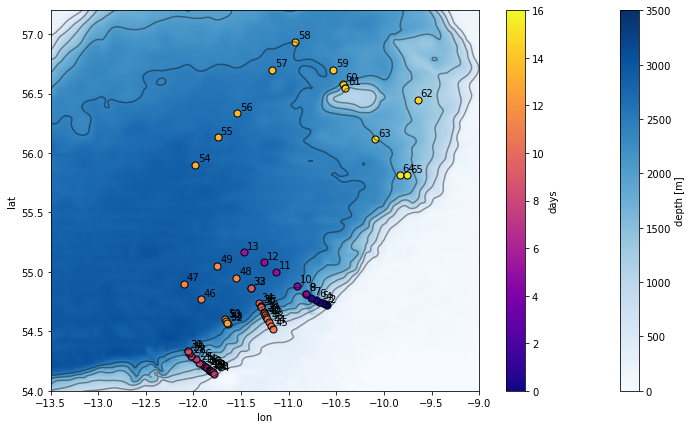

In [114]:
fig = plt.figure(figsize=(12, 7))
ax = plt.subplot()
pc = rockall.plot(cmap='Blues')
rockall.plot.contour(levels=np.arange(400., 2800., 400), colors="k", alpha=0.4)
pc1 = blt1_canyon.plot(cmap="Blues", add_colorbar=False)
pc1.set_clim(0, 3500)
pc2 = blt2_canyon.plot(cmap="Blues", add_colorbar=False)
pc2.set_clim(0, 3500)
pc.set_clim(0, 3500)

blt2_stations = list(range(2, 67))

tinit = read_ctd("BLT2", 2, return_diag=False)
tinit = tinit['timeJ'].iloc[0]
for i, stn in enumerate(blt2_stations):
    ctd = read_ctd("BLT2", stn, return_diag=False).iloc[0]
    sc = plt.scatter(ctd["longitude"], ctd["latitude"], s=50, c=[ctd['timeJ']-tinit],
                     cmap=plt.get_cmap('plasma'), linewidth=1, edgecolor="k", vmin=0, vmax=16, alpha=1.)
    plt.annotate(str(stn), xy=(ctd['longitude']+3e-2, ctd['latitude']+3e-2), color="k")
    
plt.colorbar(sc, label="days")
plt.xlim(-13.5, -9)
plt.ylim(54, 57.2);

In [110]:
ctd

prDM          2.100000e+01
t090C         1.341030e+01
t190C         1.340970e+01
c0mS/cm       4.160736e+01
c1mS/cm       4.160372e+01
sbeox0V       3.578100e+00
latitude      5.581500e+01
longitude    -9.833890e+00
timeJ         2.872262e+02
scan          7.656000e+03
ptempC        1.301000e+01
modError      0.000000e+00
CStarTr0      9.604140e+01
flC           4.420000e-01
timeQ         6.875043e+08
timeY         1.634189e+09
altM          9.113000e+01
sbeox0ML/L    5.722200e+00
sal00         3.522240e+01
sal11         3.521950e+01
flag          0.000000e+00
DEPTH         2.080821e+01
Name: 17, dtype: float64

(54.6, 55.25)

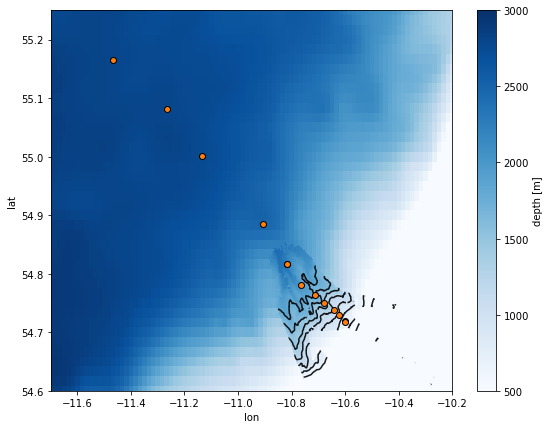

In [459]:
fig = plt.figure(figsize=(9, 7))
ax = plt.subplot()
pc = rockall.plot(cmap='Blues')
pc2 = blt2_canyon.plot(cmap="Blues", add_colorbar=False)
blt2_canyon.plot.contour(levels=np.arange(0., 2000., 200), colors="k", alpha=0.9)
pc2.set_clim(500, 3000)
pc.set_clim(500, 3000)

blt2_stations = list(range(1, 14))
for i, stn in enumerate(blt2_stations):
    ladcp = read_ladcp("BLT2", stn)
    plt.plot(ladcp["lon"], ladcp["lat"], "C1o", markeredgecolor="k")
    
plt.xlim(-11.7, -10.2)
plt.ylim(54.6, 55.25)

(54.675, 54.8)

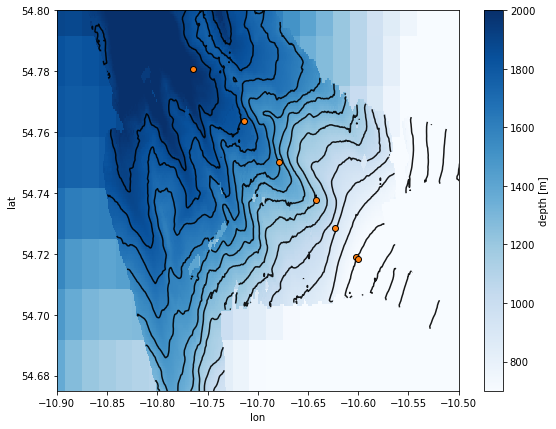

In [460]:
fig = plt.figure(figsize=(9, 7))
ax = plt.subplot()
pc = rockall.plot(cmap='Blues')
pc2 = blt2_canyon.plot(cmap="Blues", add_colorbar=False)
blt2_canyon.plot.contour(levels=np.arange(0., 2000., 100), colors="k", alpha=0.9)
pc2.set_clim(700, 2000)
pc.set_clim(700, 2000)

blt2_stations = list(range(1, 14))
for i, stn in enumerate(blt2_stations):
    ladcp = read_ladcp("BLT2", stn)
    plt.plot(ladcp["lon"], ladcp["lat"], "C1o", markeredgecolor="k")
    
plt.xlim(-10.9, -10.5)
plt.ylim(54.675, 54.8)

(54.1, 54.4)

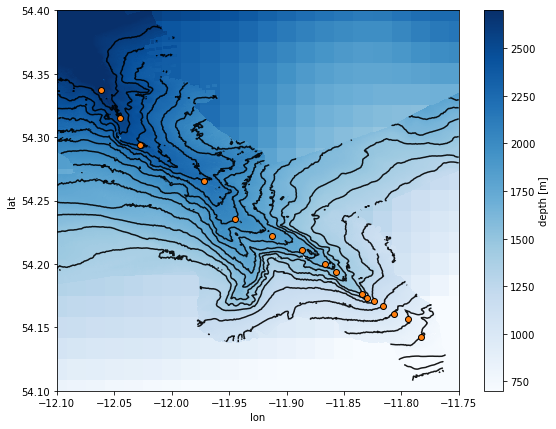

In [461]:
fig = plt.figure(figsize=(9, 7))
ax = plt.subplot()
pc = rockall.plot(cmap='Blues')
pc1 = blt1_canyon.plot(cmap="Blues", add_colorbar=False)
blt1_canyon.plot.contour(levels=np.arange(0., 2700., 100), colors="k", alpha=0.9)
pc1.set_clim(700, 2700)
pc.set_clim(700, 2700)

blt2_stations = list(range(1, 31))
for i, stn in enumerate(blt2_stations):
    ladcp = read_ladcp("BLT2", stn)
    plt.plot(ladcp["lon"], ladcp["lat"], "C1o", markeredgecolor="k")
    
plt.xlim(-12.1, -11.75)
plt.ylim(54.1, 54.4)